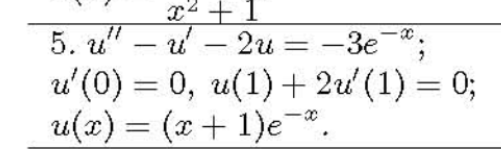

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from funcs import *
from scipy.sparse import diags
from IPython.display import display, Math
from matplotlib.animation import FuncAnimation
import multiprocess as mp
from scipy.interpolate import BSpline
from scipy.linalg import solve

## 1. Задача Коши для обыкновенного дифференциального уравнения 1 порядка

In [2]:
f = lambda x, y: (x + 2 * y) / x

n = 600
a = 0.1
b = 1.5
y0 = -0.09

x_linspace = np.linspace(a, b, 100)

In [3]:
def euler(f, y0, a, b, n):
    x = np.linspace(a, b, n + 1)
    h = (b - a) / n
    y = np.zeros_like(x)
    y[0] = y0

    for i in range(1, n + 1):

        y[i] = y[i - 1] + h * f(
            x[i - 1],
            y[i - 1],
        )

    return x, y

In [4]:
def euler_modified(f, y0, a, b, n):
    x = np.linspace(a, b, n + 1)
    h = (b - a) / n
    y = np.zeros_like(x)
    y[0] = y0

    for i in range(1, n + 1):
        y_pred = y[i - 1] + h * f(x[i - 1], y[i - 1])

        y[i] = y[i - 1] + h / 2 * (f(x[i - 1], y[i - 1]) + f(x[i], y_pred))

    return x, y

In [5]:
def runge_kutta(
    f,
    y0,
    a,
    b,
    n,
):
    x = np.linspace(a, b, n + 1)
    h = (b - a) / n
    y = np.zeros_like(x)
    y[0] = y0

    for i in range(1, n + 1):
        k1 = f(x[i - 1], y[i - 1])
        k2 = f(x[i - 1] + h / 2, y[i - 1] + h / 2 * k1)
        k3 = f(x[i - 1] + h / 2, y[i - 1] + h / 2 * k2)
        k4 = f(x[i - 1] + h, y[i - 1] + h * k3)
        y[i] = y[i - 1] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return x, y

In [6]:
x, C1 = sp.symbols("x C1")
y = sp.Function("y")(x)

In [7]:
diff_eq = sp.Eq(y.diff(x), f(x, y))

solution = sp.dsolve(diff_eq)

print("Общее решение:")
display(Math(f"y(x) = {sp.latex(solution.rhs)}"))

Общее решение:


<IPython.core.display.Math object>

In [8]:
diff_eq

Eq(Derivative(y(x), x), (x + 2*y(x))/x)

In [9]:
particular = solution.subs(C1, 1)

exact_solution = sp.lambdify(x, particular.rhs, "numpy")

print("Частное решение:")
display(Math(f"y(x) = {sp.latex(particular.rhs)}"))

Частное решение:


<IPython.core.display.Math object>

In [10]:
exact_solution(b)
euler_solution = euler(f, y0, a, b, n)
euler_modified_solution = euler_modified(f, y0, a, b, n)
runge_kutta_solution = runge_kutta(f, y0, a, b, n)

In [11]:
print(
    f"""
Точное решение в точке b: {exact_solution(b)}
Метод Эйлера: {euler_solution[1][-1]}
Модифицированный метод Эйлера: {euler_modified_solution[1][-1]}
Метод Рунге-Кутта: {runge_kutta_solution[1][-1]}

Ошибка Эйлера: {abs(exact_solution(b) - euler_solution[1][-1])}
Ошибка модифицированного метода Эйлера: {abs(exact_solution(b) - euler_modified_solution[1][-1])}
Ошибка метода Рунге-Кутта: {abs(exact_solution(b) - runge_kutta_solution[1][-1])}
"""
)


Точное решение в точке b: 0.75
Метод Эйлера: 0.7021172638436505
Модифицированный метод Эйлера: 0.7494044203236966
Метод Рунге-Кутта: 0.749999959479754

Ошибка Эйлера: 0.047882736156349526
Ошибка модифицированного метода Эйлера: 0.0005955796763034149
Ошибка метода Рунге-Кутта: 4.0520246047393016e-08



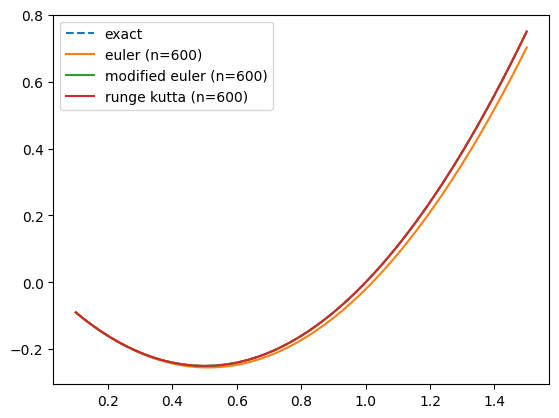

In [12]:
plt.plot(
    x_linspace,
    exact_solution(x_linspace),
    label="exact",
    linestyle="--",
)

plt.plot(
    *euler(
        f,
        y0=y0,
        a=a,
        b=b,
        n=n,
    ),
    label=f"euler (n={n})",
)

plt.plot(
    *euler_modified(
        f,
        y0=y0,
        a=a,
        b=b,
        n=n,
    ),
    label=f"modified euler (n={n})",
)

plt.plot(
    *runge_kutta(
        f,
        y0=y0,
        a=a,
        b=b,
        n=n,
    ),
    label=f"runge kutta (n={n})",
)

plt.legend()

## 2. Краевая задача для обыкновенного дифференциального уравнения второго порядка

- в файле Лаб.раб.2.pdf используйте таблицу 2
- в файле Лаб.5-9.pdf стр 28
- вариант: 5

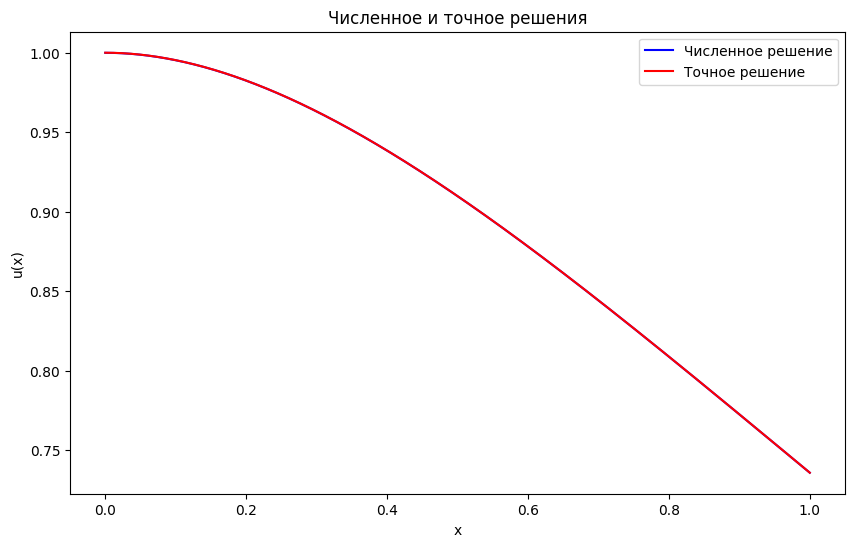

In [13]:
N = 10000
x0, xN = 0, 1
h = (xN - x0) / N
x = np.linspace(x0, xN, N + 1)
U_exact = (x + 1) * np.exp(-x)

p = -1
q = -2
f = -3 * np.exp(-x)

r = p * h / 2
a = (np.abs(r) + np.exp(-np.abs(r)) - r) / h**2
c = (np.abs(r) + np.exp(-np.abs(r)) + r) / h**2
b = -a - c + q

A = np.zeros((N + 1, N + 1))
F = np.zeros(N + 1)

for i in range(1, N):
    A[i, i - 1] = a
    A[i, i] = b
    A[i, i + 1] = c
    F[i] = f[i]

# Граничные условия
# u'(0) = 0 -> (u1 - u0) / h = 0
A[0, 0] = 1
A[0, 1] = -1
F[0] = 0

# u(1) + 2u'(1) = 0 -> uN + 2 (uN - uN-1) / h = 0
A[N, N] = 1 + 2 / h
A[N, N - 1] = -2 / h
F[N] = 0

U = np.linalg.solve(A, F)

plt.figure(figsize=(10, 6))
plt.plot(x, U, "b-", label="Численное решение")
plt.plot(x, U_exact, "r-", label="Точное решение")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Численное и точное решения")
plt.show()

In [14]:
print(f"x=0: {np.abs(U[0] - U_exact[0])}")
print(f"x=1: {np.abs(U[-1] - U_exact[-1])}")

x=0: 5.1528839657977166e-05
x=1: 2.2524721049577145e-05


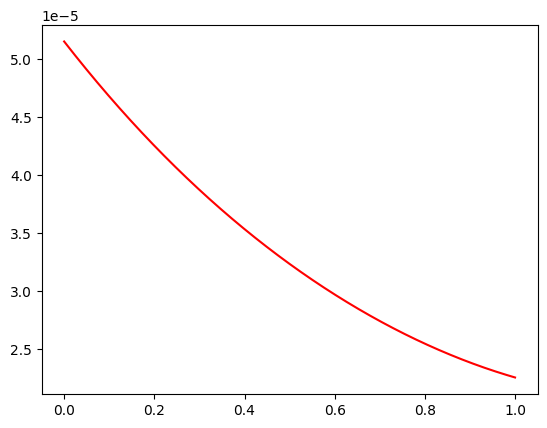

In [15]:
plt.plot(x, np.abs(U - U_exact), "r-", label="Точное решение")

## 3. Смешанная задача для уравнения теплопроводности

In [16]:
def exact(x, t):
    return np.exp(-np.pi * t) * np.sin(np.pi * x / 4)


def heat_equation_explicit(L, T, Nx, Nt, alpha, u_init, mu, beta):
    dx = L / Nx
    dt = T / Nt
    r = alpha * dt / dx**2

    if r > 0.5:
        print("Предупреждение: схема может быть неустойчивой")

    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)

    u = np.zeros((Nt + 1, Nx + 1))
    u[0, :] = u_init(x)

    for n in range(0, Nt):
        for i in range(1, Nx):
            u[n + 1, i] = u[n, i] + r * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1])

        u[n + 1, 0], u[n + 1, -1] = mu(t[n + 1]), beta(t[n + 1])

    return u


def heat_equation_cn(L, T, Nx, Nt, alpha, u_init, mu, beta):
    dx = L / Nx
    dt = T / Nt
    r = alpha * dt / (2 * dx**2)

    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)

    u = np.zeros((Nt + 1, Nx + 1))
    u[0, :] = u_init(x)

    A = diags([-r, 1 + 2 * r, -r], [-1, 0, 1], shape=(Nx - 1, Nx - 1)).toarray()
    B = diags([r, 1 - 2 * r, r], [-1, 0, 1], shape=(Nx - 1, Nx - 1)).toarray()

    for n in range(0, Nt):
        b = B @ u[n, 1:Nx]
        u[n + 1, 1:Nx] = np.linalg.solve(A, b)
        u[n + 1, 0], u[n + 1, -1] = mu(t[n + 1]), beta(t[n + 1])

    return u

In [17]:
L = 4
T = 1
N = 10
M = 100
alpha = 16 / np.pi

x = np.linspace(0, L, N + 1)
t = np.linspace(0, T, M + 1)

u_init = lambda x: np.sin(np.pi * x / 4)
mu = lambda t: 0
beta = lambda t: 0

In [18]:
u_explicit = heat_equation_explicit(L, T, N, M, alpha, u_init, mu, beta)
u_cn = heat_equation_cn(L, T, N, M, alpha, u_init, mu, beta)

X, T_grid = np.meshgrid(x, t)
u_exact = exact(X, T_grid)

error_explicit = np.abs(u_explicit - u_exact)
error_cn = np.abs(u_cn - u_exact)

print(np.max(error_explicit), np.max(error_cn))

0.0027787935890145055 0.00299840305263277


## 4. Смешанная задача для уравнения гиперболического типа

In [19]:
def solve_hyperbolic_eq(a, l, T, h, tau, phi, psi, mu1, mu2, f=lambda x, t: 0):
    """
    Решает волновое уравнение с помощью явной разностной схемы.

    Параметры:
        a: скорость волны (a > 0)
        l: длина струны (пространственный интервал [0, l])
        T: конечное время
        h: шаг по пространству
        tau: шаг по времени
        phi: начальное условие u(x, 0) = phi(x)
        psi: начальная скорость du/dt(x, 0) = psi(x)
        mu1, mu2: граничные условия u(0, t) = mu1(t), u(l, t) = mu2(t)
        f: функция источника f(x, t) (по умолчанию 0)
    """

    Nx = int(l / h) + 1
    Nt = int(T / tau) + 1
    x = np.linspace(0, l, Nx)
    t = np.linspace(0, T, Nt)

    u = np.zeros((Nt, Nx))

    for i in range(Nx):
        u[0, i] = phi(x[i])

    for i in range(1, Nx - 1):
        u[1, i] = (
            u[0, i]
            + tau * psi(x[i])
            + (a**2 * tau**2 / (2 * h**2)) * (u[0, i + 1] - 2 * u[0, i] + u[0, i - 1])
            + (tau**2 / 2) * f(x[i], 0)
        )

    u[1, 0] = mu1(t[1])
    u[1, -1] = mu2(t[1])

    for n in range(1, Nt - 1):
        for i in range(1, Nx - 1):
            u[n + 1, i] = (
                2 * u[n, i]
                - u[n - 1, i]
                + (a**2 * tau**2 / h**2) * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
                + tau**2 * f(x[i], t[n])
            )

        u[n + 1, 0] = mu1(t[n + 1])
        u[n + 1, -1] = mu2(t[n + 1])

    return x, t, u

11


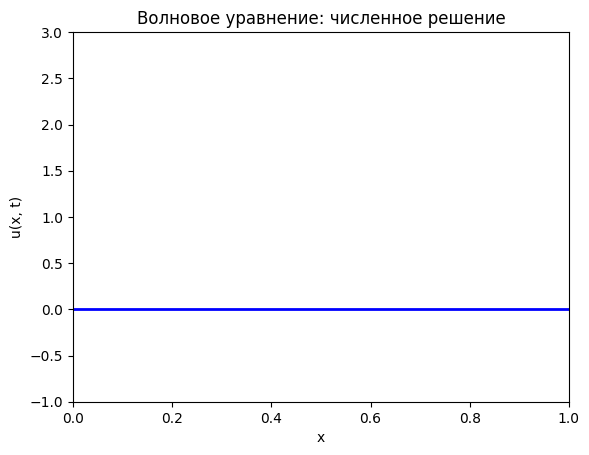

In [20]:
a = 1
l = 1
T = 1
N = 10
M = 10

h = l / N
tau = T / M

phi = lambda x: 0
psi = lambda x: 0
mu1 = lambda t: t**2 - t
mu2 = lambda t: 3 * t**2
f = lambda x, t: 0

x, t, u = solve_hyperbolic_eq(a, l, T, h, tau, phi, psi, mu1, mu2, f)

fig, ax = plt.subplots()
(line,) = ax.plot(x, u[0, :], "b-", lw=2)
ax.set_xlim(0, l)
ax.set_ylim(-1, 3)
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
ax.set_title("Волновое уравнение: численное решение")

print(len(t))

start_frame = 0


def update(frame):
    actual_frame = (start_frame + frame) % len(t)
    line.set_ydata(u[actual_frame, :])
    ax.set_title(f"Волновое уравнение: t = {t[actual_frame]:.2f}")
    return (line,)


line.set_ydata(u[start_frame, :])

ani = FuncAnimation(fig, update, frames=len(t), interval=50)


# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")

# X, T = np.meshgrid(x, t)

# surf = ax.plot_surface(X, T, u, cmap="viridis")

# ax.set_xlabel("x")
# ax.set_ylabel("t")
# ax.set_zlabel("u(x,t)")
# ax.set_title("Волновое уравнение: трехмерное решение")

# ax.view_init(elev=30, azim=45)

plt.show()

## 5. Метод Ритца

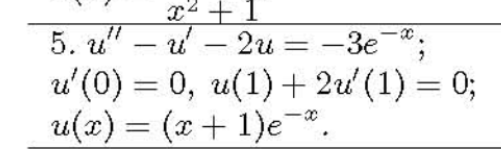

In [21]:
a = 0
b = 1

p_x = lambda x: sp.exp(-x)
q_x = lambda x: -2 * p_x(x)
f_x = lambda x: -3 * sp.exp(-x) * p_x(x)

u_exact = lambda x: (x + 1) * np.exp(-x)

begin = u_exact(a)
end = u_exact(b)

phi_0 = lambda x: begin + (end - begin) * x
dphi_0 = lambda x: end - begin

phi_k = lambda x, k: x * k * (1 - x) ** (2 * k)
dphi_k = lambda x, k: k * (1 - x) ** (2 * k) - 2 * k**2 * x * (1 - x) ** (2 * k - 1)

N = 2

In [22]:
u_x = lambda x, C_s: phi_0(x) + sum([C_s[k - 1] * phi_k(x, k) for k in range(1, N + 1)])

x = sp.Symbol("x", real=True)
C_s = sp.symbols(f"c:{N}")

F_int_i = lambda i: (
    2
    * p_x(x)
    * (dphi_0(x) + sum([C_s[j] * dphi_k(x, j + 1) for j in range(N)]))
    * dphi_k(x, i + 1)
    - 2
    * q_x(x)
    * (phi_0(x) + sum([C_s[j] * phi_k(x, j + 1) for j in range(N)]))
    * phi_k(x, i + 1)
    + 2 * f_x(x) * phi_k(x, i + 1)
)


F_ints = [sp.integrate(F_int_i(i), (x, a, b)).expand() for i in range(N)]

A = np.zeros((N, N))
B = np.zeros(N)


for i in range(N):
    for j in range(N):
        A[i, j] = F_ints[i].coeff(C_s[j])

    B[i] = -1 * F_ints[i].subs({C_s[j]: 0 for j in range(N)})

C_s_sol = np.linalg.solve(A, B)
u_x_sol = u_x(x, C_s_sol)

xs = np.linspace(a, b, 1000)

u_exact = u_exact(xs)
u_sol = np.array([u_x_sol.subs(x, i) for i in xs], dtype=float)

In [23]:
max_error = np.max(np.abs(u_exact - u_sol))
mean_error = np.mean(np.abs(u_exact - u_sol))

Максимальная ошибка: 0.009708434276948119
Средняя ошибка: 0.003944246471748323


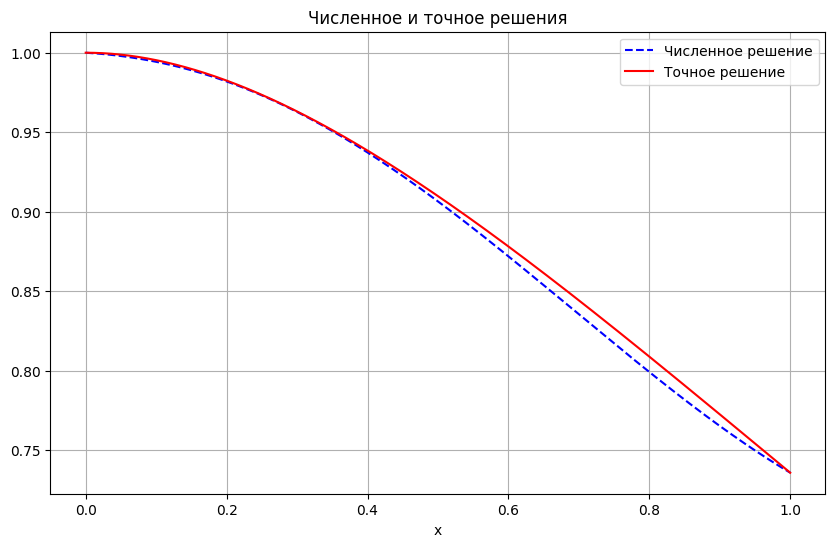

In [24]:
print(f"Максимальная ошибка: {max_error}")
print(f"Средняя ошибка: {mean_error}")

plt.figure(figsize=(10, 6))
plt.plot(
    xs,
    u_sol,
    "b",
    label="Численное решение",
    linestyle="--",
)

plt.plot(
    xs,
    u_exact,
    "r",
    label="Точное решение",
)

plt.xlabel("x")
plt.legend()
plt.title("Численное и точное решения")
plt.grid()
plt.show()

## 6. Метод Галеркина

In [25]:
N = 10  # приемлемо N = 7

x, k = sp.symbols("x k", real=True)
C_s = sp.symbols(f"c:{N}")

In [26]:
a = 0
b = 1

left = lambda u: sp.diff(u, x, 2) - sp.diff(u, x) - 2 * u
right = lambda x: -3 * sp.exp(-x)

u_exact = lambda x: (x + 1) * np.exp(-x)

In [27]:
begin = u_exact(a)
end = u_exact(b)

In [28]:
phi_0 = begin + (end - begin) * x
phi_k = sp.sin(k * sp.pi * x)

In [29]:
dphi_0 = sp.diff(phi_0)
dphi_k = sp.diff(phi_k, x)

In [30]:
u = phi_0 + sum(C_s[i] * phi_k.subs(k, i) for i in range(1, N))
R = left(u) - right(x)

In [31]:
def calculate_equation(i, sympy_lib, phi_k, R, x, k, a, b):
    l = sympy_lib.integrate(phi_k.subs(k, i) * R, (x, a, b))
    return sympy_lib.Eq(l, 0)


pool = mp.Pool(processes=mp.cpu_count())

args = [(i, sp, phi_k, R, x, k, a, b) for i in range(1, N)]

equations = pool.starmap(calculate_equation, args)

pool.close()
pool.join()

In [32]:
solution = sp.solve(equations, C_s)
solution_l = list(solution.values())

In [33]:
for i in range(1, N):
    u = u.subs(C_s[i], solution_l[i - 1])

In [34]:
u

-0.264241117657115*x + 0.0438221384543135*sin(pi*x) + 0.00761598041647154*sin(2*pi*x) + 0.00228840458518098*sin(3*pi*x) + 0.000992376586859193*sin(4*pi*x) + 0.000506850911486641*sin(5*pi*x) + 0.000295818315616675*sin(6*pi*x) + 0.000185280497269638*sin(7*pi*x) + 0.000124627033817411*sin(8*pi*x) + 8.59480415200561e-5*sin(9*pi*x) + 1.0

In [35]:
u = sp.lambdify(x, u, modules=["numpy"])

x = np.linspace(a, b, 100)

u = u(x)
u_exact = u_exact(x)

In [36]:
print(f"max: {np.max(np.abs(u - u_exact))}\navg: {np.mean(np.abs(u - u_exact))}")

max: 0.00027922616519726606
avg: 4.949072785237596e-05


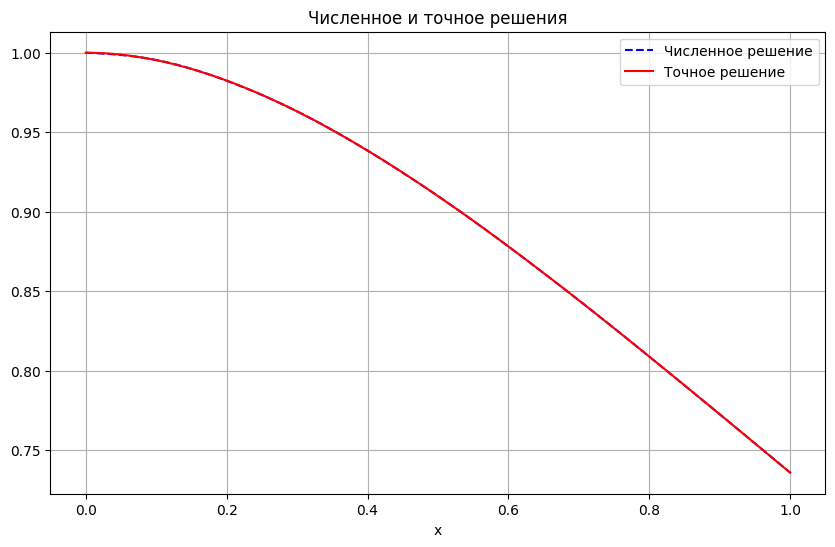

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(
    x,
    u,
    "b",
    label="Численное решение",
    linestyle="--",
)

plt.plot(
    x,
    u_exact,
    "r",
    label="Точное решение",
)

plt.xlabel("x")
plt.legend()
plt.title("Численное и точное решения")
plt.grid()
plt.show()

## 7. Метод сплайн-коллокации (с использованием В-сплайнов)

In [38]:
a, b = 0, 1
f = lambda x: -3 * np.exp(-x)
u_exact = lambda x: (x + 1) * np.exp(-x)

# k10n10, k12n8
k = 10
n_intervals = 10
n_basis = n_intervals + k

In [39]:
internal_knots = np.linspace(a, b, n_basis - k + 1)
t = np.concatenate((np.full(k, a), internal_knots, np.full(k, b)))

m = n_basis - 2
x_coll = np.linspace(a + 1e-6, b - 1e-6, m)

A = np.zeros((n_basis, n_basis))
rhs = np.zeros(n_basis)

In [40]:
for i in range(n_basis):
    coeff = np.zeros(n_basis)
    coeff[i] = 1
    B = BSpline(t, coeff, k)
    B_d = B.derivative(nu=1)
    B_dd = B.derivative(nu=2)

    for j, xj in enumerate(x_coll):
        A[j, i] = B_dd(xj) - B_d(xj) - 2 * B(xj)

for i in range(n_basis):
    coeff = np.zeros(n_basis)
    coeff[i] = 1
    B = BSpline(t, coeff, k)
    B_d = B.derivative(nu=1)
    A[m, i] = B_d(a)

for i in range(n_basis):
    coeff = np.zeros(n_basis)
    coeff[i] = 1
    B = BSpline(t, coeff, k)
    B_d = B.derivative(nu=1)
    A[m + 1, i] = B(b) + 2 * B_d(b)

In [41]:
rhs[:m] = f(x_coll)
rhs[m] = 0
rhs[m + 1] = 0

c = solve(A, rhs)

x_vals = np.linspace(a, b, 500)
y_vals = np.zeros_like(x_vals)

for i in range(n_basis):
    coeff = np.zeros(n_basis)
    coeff[i] = 1
    B = BSpline(t, coeff, k)
    y_vals += c[i] * B(x_vals)

u_exact_vals = u_exact(x_vals)

In [42]:
print(
    f"max: {np.max(np.abs(y_vals - u_exact_vals))}\navg: {np.mean(np.abs(y_vals - u_exact_vals))}"
)

max: 5.913047829153584e-13
avg: 4.4498515983093514e-13


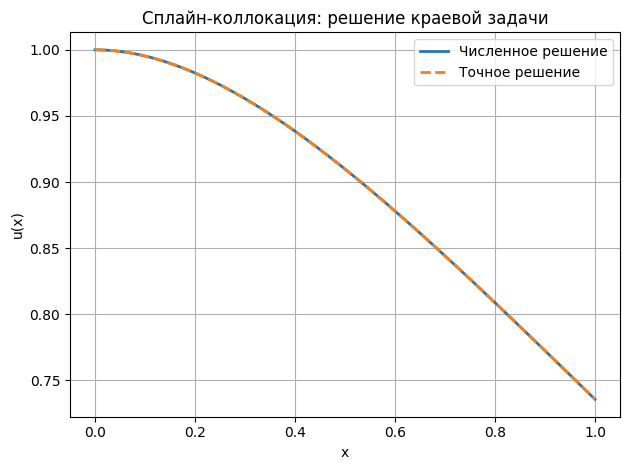

In [43]:
plt.plot(x_vals, y_vals, label="Численное решение", linewidth=2)
plt.plot(x_vals, u_exact_vals, "--", label="Точное решение", linewidth=2)
plt.title("Сплайн-коллокация: решение краевой задачи")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()